In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
})

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
import os

/Users/matthewcox/miniforge3/envs/mol-cov/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015825353944638465, tolerance: 0.0012885517885079293
  model = cd_fast.enet_coordinate_descent_gram(
/Users/matthewcox/miniforge3/envs/mol-cov/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015141259883275637, tolerance: 0.0012964311249461964
  model = cd_fast.enet_coordinate_descent_gram(
/Users/matthewcox/miniforge3/envs/mol-cov/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020735649492166774, tolerance: 0.0014745616931449812
  model = cd_fast.enet_coordinate_

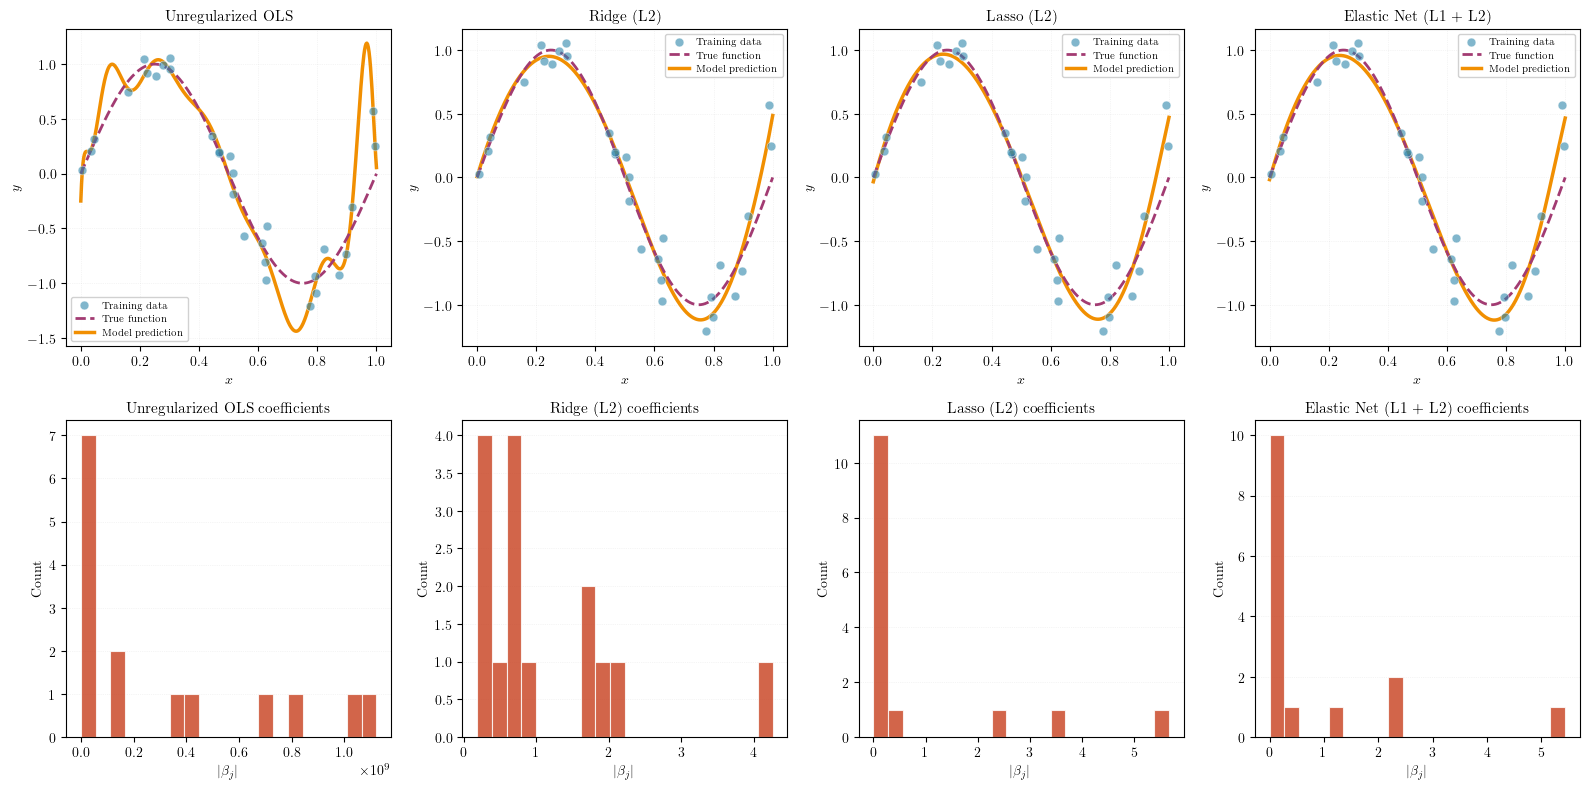

Figure saved to: ../../../figs/models_vs_data/regularization_comparison.png


In [ ]:
out_dir = "../../../figs/models-vs-data/"

colors = {
    'train': '#2E86AB',      # blue
    'true': '#A23B72',       # purple
    'pred': '#F18F01',       # orange
    'hist': '#C73E1D'        # red
}

rng = np.random.default_rng(7)
N_train = 30
N_test = 200

X_train = rng.uniform(0, 1, size=(N_train, 1))
noise = rng.normal(0, 0.25 * (0.3 + X_train.squeeze()**2), size=N_train)
y_train = np.sin(2 * np.pi * X_train.squeeze()) + noise

X_plot = np.linspace(0, 1, 400).reshape(-1, 1)
X_test = np.linspace(0, 1, N_test).reshape(-1, 1)
y_test_true = np.sin(2 * np.pi * X_test.squeeze())
y_test = y_test_true + rng.normal(0, 0.25 * (0.3 + X_test.squeeze()**2), size=N_test)

degree = 15
poly = PolynomialFeatures(degree=degree, include_bias=False)

def make_pipe(estimator):
    return Pipeline([
        ("poly", poly),
        ("scaler", StandardScaler(with_mean=False)),
        ("model", estimator),
    ])

models = [
    (r"Unregularized OLS", make_pipe(LinearRegression())),
    (r"Ridge (L2)", make_pipe(RidgeCV(alphas=np.logspace(-4, 3, 50)))),
    (r"Lasso (L2)", make_pipe(LassoCV(alphas=np.logspace(-4, 1, 50), max_iter=50000, cv=10))),
    (r"Elastic Net (L1 + L2)", make_pipe(ElasticNetCV(l1_ratio=[0.2, 0.5, 0.8], alphas=np.logspace(-4, 1, 50), max_iter=50000, cv=10)))
]

preds = {}
coefs = {}

for name, pipe in models:
    pipe.fit(X_train, y_train)
    preds[name] = pipe.predict(X_plot)
    model = pipe.named_steps["model"]
    coefs[name] = np.concatenate(([model.intercept_], model.coef_.ravel()))

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for idx, (name, _) in enumerate(models):
    ax = axes[0, idx]
    ax.scatter(X_train, y_train, alpha=0.6, s=40, color=colors['train'], 
               edgecolors='white', linewidth=0.5, label=r"Training data", zorder=3)
    ax.plot(X_plot, np.sin(2 * np.pi * X_plot.squeeze()), '--', 
            color=colors['true'], linewidth=2, label=r"True function", zorder=2)
    ax.plot(X_plot, preds[name], '-', color=colors['pred'], 
            linewidth=2.5, label=r"Model prediction", zorder=1)
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")
    ax.set_title(name, fontsize=11)
    ax.legend(fontsize=7, loc='best', framealpha=0.9)
    ax.grid(True, alpha=0.25, linestyle=':', linewidth=0.5)
    ax.set_xlim(-0.05, 1.05)

for idx, (name, _) in enumerate(models):
    ax = axes[1, idx]
    coef = coefs[name][1:]  # skip intercept
    abscoef = np.abs(coef)
    ax.hist(abscoef, bins=20, color=colors['hist'], edgecolor='white', 
            alpha=0.8, linewidth=0.8)
    ax.set_xlabel(r"$|\beta_j|$")
    ax.set_ylabel(r"Count")
    ax.set_title(name + r" coefficients", fontsize=11)
    ax.grid(True, alpha=0.25, linestyle=':', linewidth=0.5, axis='y')
    ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig(os.path.join(out_dir, "regularization_comparison.pdf"), bbox_inches='tight', transparent=True)
plt.show()